> GAN 모형 만들기 (mnist-keras)

Conv2D 합성곱층 (사이즈 줄어듬)
Conv2DTranspose 역합성곱층 (생성모델에서 사용, 늘어남)

In [1]:
# 데이터셋
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (_, _) = mnist.load_data()

In [2]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
# [-1, 1]로 정규화

In [6]:
# 미니배치로 나누고 섞음
BUFFER_SIZE = 60000
BATCH_SIZE = 256

import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
# 생성 모형
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense,BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose,BatchNormalization

def make_generator_model():
    model = Sequential()

    # use_bias=F , bias를 생성하지 않음
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
                    #output
    model.add(BatchNormalization()) #미니배치에 대한 정규화
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256))) # 출력된 값을 reshape

    # 역합성곱층
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2),
                padding='same', use_bias=False, activation='tanh'))
    # tanh : -1~1 사이 결과가 나옴
    return model

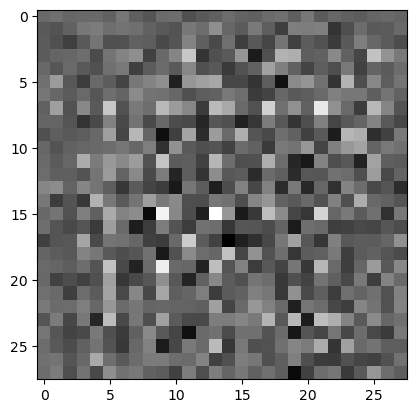

In [8]:
#생성 모형 테스트
import matplotlib.pyplot as plt

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [10]:
#판별 모형
from tensorflow.keras.layers import Conv2D, Dropout, Flatten

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                    #아웃  필터      쉬프트
                    input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00225169]], shape=(1, 1), dtype=float32)


In [13]:
# 판별모형 손실함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
# 생성모형 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
import os
checkpoint_dir = 'c:/vscode/data/mnist/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                        discriminator_optimizer=discriminator_optimizer,
                        generator=generator,
                        discriminator=discriminator)

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# 학습 과정
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 이미지저장
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) 
        #training=False: 추론모드, 순전파만 하고 역전파가 없는 상태
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [33]:
import time
from IPython import display

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        # GIF 이미지 생성
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

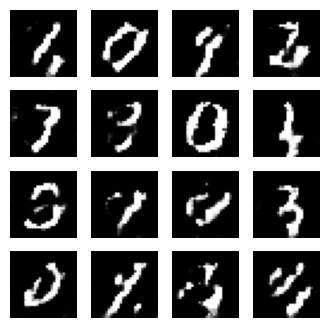

Time for epoch 5 is 138.20586800575256 sec


KeyboardInterrupt: 

In [34]:
%%time
#오래걸림
train(train_dataset, EPOCHS)

In [35]:
#체크 포인트 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

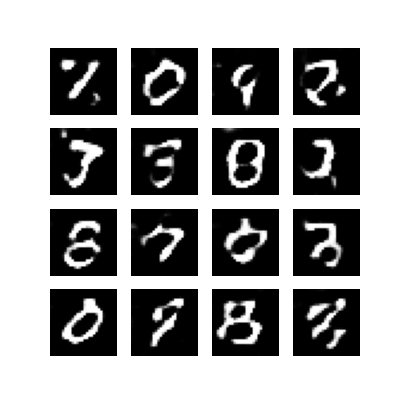

In [37]:
#gif 생성
import imageio
import glob
anim_file = 'c:/vscode/data/mnist/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.v2.imread(filename)
        writer.append_data(image)
    image = imageio.v2.imread(filename)
    writer.append_data(image)
display.Image(filename=anim_file)

In [ ]:
# 모델 저장
#generator.save('c:/vscode/data/model/iris_generator.h5')

In [19]:
# 모델 불러오기
import tensorflow as tf
generator = tf.keras.models.load_model('c:/vscode/data/model/iris_generator.h5')
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

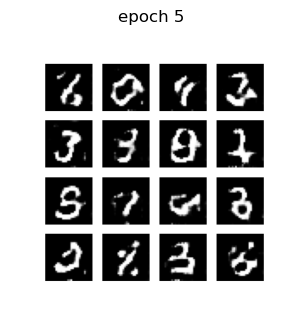

In [39]:
from matplotlib import pyplot as plt
import math
import PIL
plt.figure(figsize=(15,8))
for i in range(4,50,5):
    plt.subplot(2, 5, math.ceil((i+1)/5))
    img=PIL.Image.open('image_at_epoch_{:04d}.png'.format(i))
    plt.imshow(img, 'gray')
    plt.title(f'epoch {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

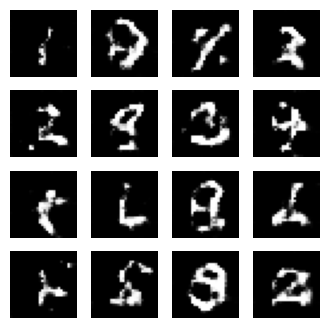

In [40]:
# 랜덤으로 이미지 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

predictions = generator(seed, training=False) 

fig = plt.figure(figsize=(4,4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

> celeba

In [55]:
%%time
#이미지 파일들을 h5py 파일로 압축하는 과정(오래걸림, 15~20분)
import h5py
import zipfile
import imageio
import os

hdf5_file = 'c:/vscode/data/celeba/celeba_aligned_small.h5py'
total_images = 20000
with h5py.File(hdf5_file, 'w') as hf:
    count = 0
    with zipfile.ZipFile('c:/vscode/data/celeba/img_align_celeba.zip', 'r') as zf:
        for i in zf.namelist():
            if (i[-4:] == '.jpg'):
                # extract image
                ofile = zf.extract(i)
                img = imageio.v2.imread(ofile)
                os.remove(ofile)
                # 이미지 데이터를 h5py 모델에 추가하는 과정
                hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img,compression="gzip", compression_opts=9)
                count = count + 1
                if count%1000 == 0:
                    print("images done .. ", count)
                if count == total_images:
                    break

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
Wall time: 4min 13s


In [56]:
import h5py
# h5py 파일 확인
with h5py.File('c:/vscode/data/celeba/celeba_aligned_small.h5py', 'r') as file_object:
    for group in file_object:
        print(group)

img_align_celeba


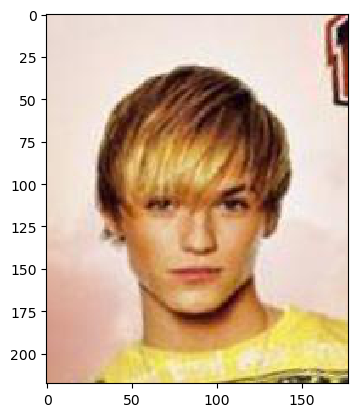

In [59]:
import matplotlib.pyplot as plt
import numpy as np
with h5py.File('c:/vscode/data/celeba/celeba_aligned_small.h5py', 'r') as fp:
    dataset = fp['img_align_celeba']
    image = np.array(dataset['104.jpg'])
    plt.imshow(image, interpolation='none')

> GAN(celeba 모형)

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce GTX 1050 Ti


In [2]:
# gpu 사용 가능 여부 확인
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

using cuda: NVIDIA GeForce GTX 1050 Ti


device(type='cuda')

In [3]:
#데이터셋 클래스
from torch.utils.data import Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    def plot_image(self, index):
        plt.imshow(np.array(self.dataset[str(index)+'.jpg']),
                    interpolation='nearest')

In [4]:
celeba_dataset = CelebADataset('c:/vscode/data/celeba/celeba_aligned_small.h5py')

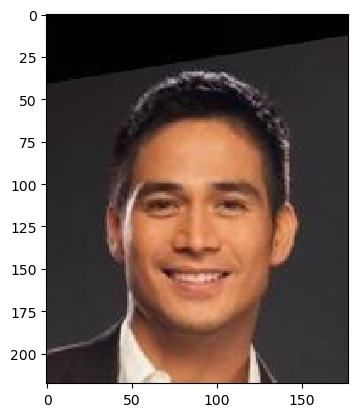

In [5]:
celeba_dataset.plot_image(11)

In [6]:
# 랜덤 데이터 생성 함수
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [10]:
import torch.nn as nn
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(self.shape) # *매개변수 : tuple

In [8]:
# 판별 모형
import pandas as pd
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
                    View(218*178*3),
                    nn.Linear(3*218*178, 100),
                    nn.LeakyReLU(),
                    nn.LayerNorm(100),
                    nn.Linear(100, 1),
                    nn.Sigmoid()
                    )
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
    def forward(self, inputs):
        return self.model(inputs)
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        if self.counter % 1000 == 0:
            print("counter = ", self.counter)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [11]:
%%time
#판별 모형 테스트(오래 걸림, 40~50분)
D = Discriminator()
D.to(device)
for image_data_tensor in celeba_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # 가짜 데이터
    D.train(generate_random_image((218,178,3)),
            torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
Wall time: 9min 40s


In [12]:
# 생성 모델
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
                    nn.Linear(100, 3*10*10),
                    nn.LeakyReLU(),
                    nn.LayerNorm(3*10*10),
                    nn.Linear(3*10*10, 3*218*178),
                    nn.Sigmoid(),
                    View((218,178,3))
                    )
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
    def forward(self, inputs):
        return self.model(inputs)
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

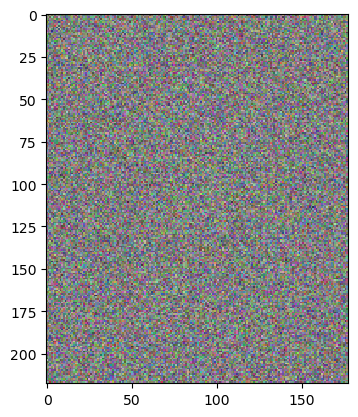

In [13]:
#생성모델 테스트
G = Generator()
G.to(device)
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [14]:
%%time
# 판독모형, 생성모형 생성
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)
epochs = 2
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for image_data_tensor in celeba_dataset:
        # 판별모형 훈련(true)
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        # 판별모형 훈련(false)
        D.train(G.forward(generate_random_seed(100)).detach(),
                torch.cuda.FloatTensor([0.0]))
        # 생성모형 훈련
        G.train(D, generate_random_seed(100),
                torch.cuda.FloatTensor([1.0]))

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

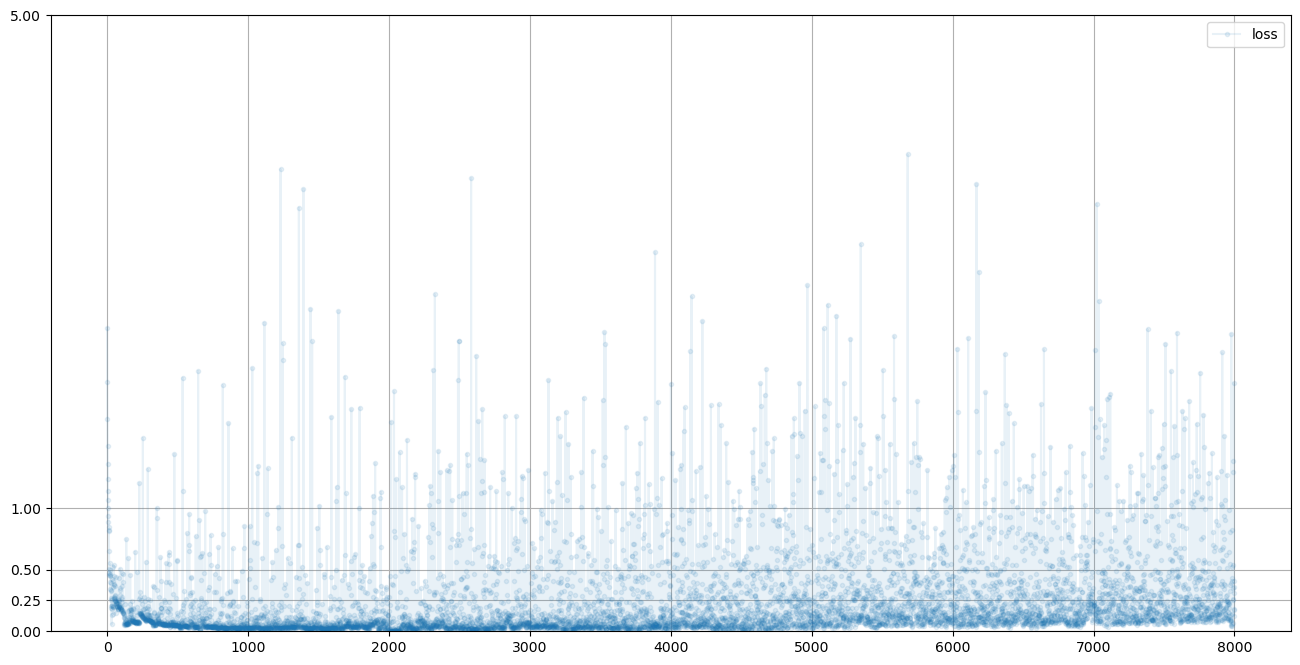

In [15]:
D.plot_progress()

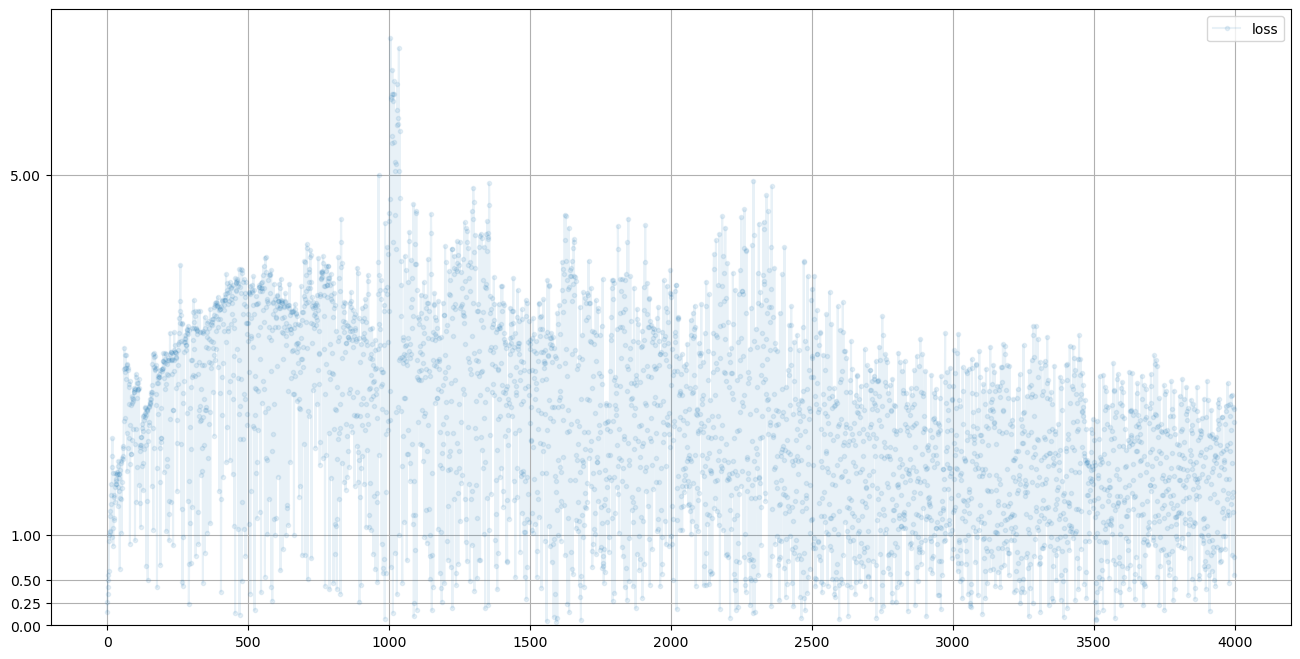

In [16]:
G.plot_progress()

In [17]:
# 모델 저장
torch.save(G,'c:/vscode/data/model/final_celeba_G.h5')

> 모델 불러오기

In [18]:
import torch
# gpu 사용 가능 여부 확인
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
device

using cuda: NVIDIA GeForce GTX 1050 Ti


device(type='cuda')

In [19]:
import torch
import torch.nn as nn
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(self.shape) # *매개변수 : tuple

In [20]:
# 생성 모델
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
                    nn.Linear(100, 3*10*10),
                    nn.LeakyReLU(),
                    nn.LayerNorm(3*10*10),
                    nn.Linear(3*10*10, 3*218*178),
                    nn.Sigmoid(),
                    View((218,178,3))
                    )
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
    def forward(self, inputs):
        return self.model(inputs)
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.',
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [22]:
G=torch.load('c:/vscode/data/model/final_celeba_G.h5')
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=300, out_features=116412, bias=True)
    (4): Sigmoid()
    (5): View()
  )
)

In [23]:
#학습된 가중치 확인
print(G.model[3].weight[0][:10])
print(G.model[3].bias[:10])

tensor([-0.0081,  0.0417,  0.0384,  0.0020, -0.0489, -0.0211, -0.0365,  0.0511,
        -0.0151, -0.0236], grad_fn=<SliceBackward0>)
tensor([-0.0379, -0.0089, -0.0510, -0.0577, -0.0358,  0.0147, -0.0323, -0.0548,
        -0.0662, -0.0548], grad_fn=<SliceBackward0>)


In [24]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

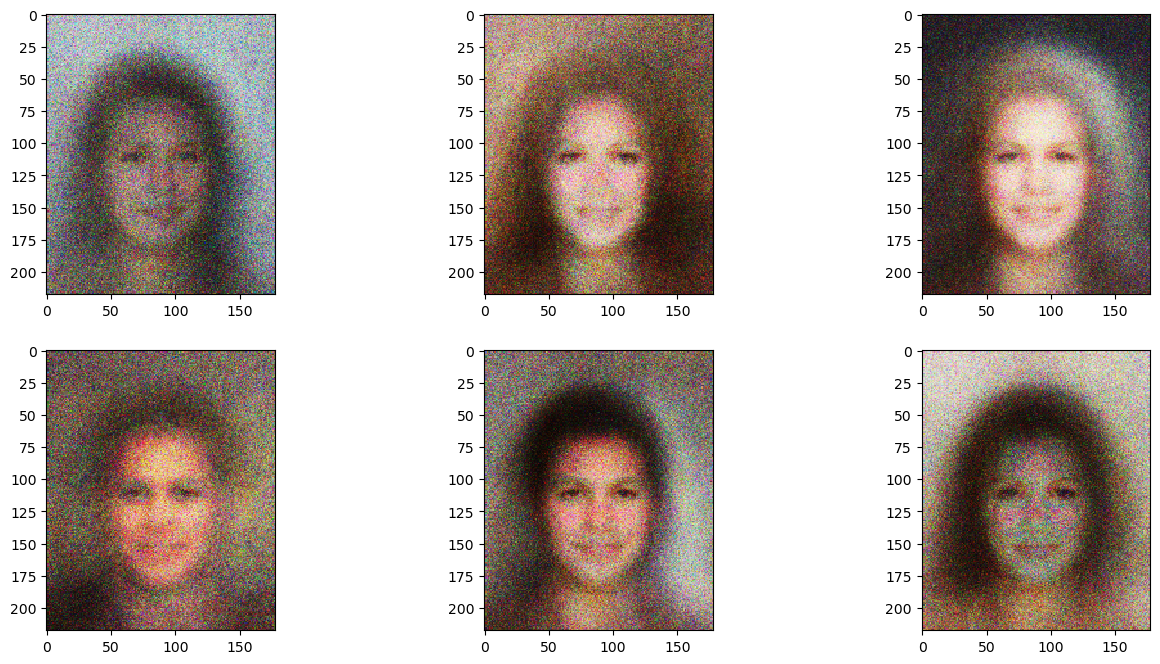

In [25]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

count = 0
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [26]:
# GPU 메모리 사용량
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.5844545364379883

In [27]:
# 실행중 최대 메모리 사용량
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.2415056228637695

In [28]:
# 메모리 사용량 통계
# abbreviated 요약 여부
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 612845 KiB |   1271 MiB |  17499 GiB |  17499 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 612845 KiB |   1271 MiB |  17499 GiB |  17499 GiB |
|---------------------------------------------------------------------------|
| Requested memory      | 610440 KiB |   1265 MiB |  17489 GiB |  17488 GiB |
|---------------------------------------------------------------